In [1]:
import numpy as np
import scipy as sp
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

## OLS

$Y = X\beta + \epsilon$

$\beta = (X'X)^{-1}X'y$

$\epsilon \sim N(0, \sigma^2)$


## Pre-whitening

$\epsilon \sim N(0, \sigma^2 V)$

V is not an identity matrix. To fix this, we find a matrix W such that

$WVW' = I$

Then,

$WY = WX\beta + W\epsilon$

and

$Cov(W\epsilon) = \sigma^2 WVW' = \sigma^2 I$

In [2]:
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = sm.datasets.longley.load()
data.exog = sm.add_constant(data.exog)

# data in X and y
X = data.exog
y = data.endog

# fit initial OLS
ols1 = np.linalg.lstsq(X, y)
betas1 = ols1[0]

# get residuals
pred = X.dot(betas1)
resid = y - pred
#plt.plot(resid)

# get AR(1) correlation
ols_ar1_resid = np.linalg.lstsq(np.vstack([np.ones(resid[:-1].shape), resid[:-1]]).T, resid[1:,np.newaxis])
rho = ols_ar1_resid[0][1]  # so lag1 correlation is -0.3668

# make W
from scipy.linalg import toeplitz
order = toeplitz(np.arange(len(y)))
V = rho ** order
W = np.linalg.cholesky(np.linalg.pinv(V))

# ok, now prewhiten
y_w = np.dot(W, y)
X_w = np.dot(W, X)

# and OLS again
ols_prew = np.linalg.lstsq(X_w, y_w)
print(ols_prew[0])

# is this the same as GLS?
gls_model = sm.GLS(y, X, sigma=V)
gls_res = gls_model.fit()
gls_res.summary().tables[1]

# not exactly the same but this may be due to the differences in inverting the matrix V and the cholesky decomposition

[-3.78372883e+06 -1.55896638e+01 -3.77110995e-02 -2.18782556e+00
 -1.15085538e+00 -6.25392984e-02  1.98648515e+03]


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/statsmodels/datasets/utils.py:100: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exog = np.column_stack(data[field] for field in exog_name)
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future d

,coef,std err,t,P>|t|,[0.025,0.975]
const,-3.798e+06,6.71e+05,-5.663,0.000,-5.32e+06,-2.28e+06
x1,-12.7656,69.431,-0.184,0.858,-169.829,144.298
x2,-0.0380,0.026,-1.448,0.182,-0.097,0.021
x3,-2.1869,0.382,-5.719,0.000,-3.052,-1.322
x4,-1.1518,0.165,-6.970,0.000,-1.526,-0.778
x5,-0.0681,0.176,-0.386,0.709,-0.467,0.331
x6,1993.9529,342.635,5.819,0.000,1218.860,2769.046


In [3]:
gls_res.summary()

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            GLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            GLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1846.
Date:                Fri, 28 Jun 2019   Prob (F-statistic):           2.21e-13
Time:                        11:08:55   Log-Likelihood:                -107.50
No. Observations:                  16   AIC:                             229.0
Df Residuals:                       9   BIC:                             234.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.798e+06   6.71e+05     -5.663      0.000   -5.32e+06   -2.28e+06
x1           -12.7656     69.431     -0.184      0.858    -169.829     144.298
x2            -0.0380      0.026     -1.448      0.182      -0.097       0.021
x3            -2.1869      0.382     -5.719      0.000      -3.052      -1.322
x4            -1.1518      0.165     -6.970      0.000      -1.526      -0.778
x5            -0.0681      0.176     -0.386      0.709      -0.467       0.331
x6          1993.9529    342.635      5.819      0.000    1218.860    2769.046
==============================================================================
Omnibus:                        1.365   Durbin-Watson:                   2.534
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                0.885
Skew:                           0.209   Prob(JB):                        0.642
Kurtosis:                       1.926   Cond. No.                     5.61e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.61e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

83642.40555046748

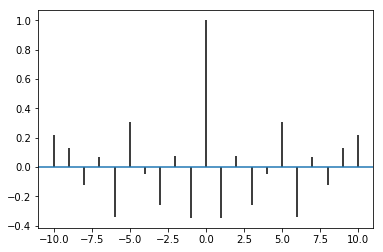

In [4]:
# original OLS residuals
plt.acorr(resid)

sigma2 = resid.dot(resid) / (len(y_w)-X.shape[1]+1)
sigma2

73345.81510097875

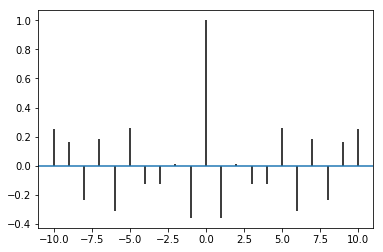

In [5]:
# Pre-whitened OLS residuals
ols_prew_resid = y_w - X_w.dot(ols_prew[0])
plt.acorr(ols_prew_resid)

#
sigma2 = ols_prew_resid.dot(ols_prew_resid) / (len(y_w)-X.shape[1]+1)
sigma2  # less than before

92013.11734222082

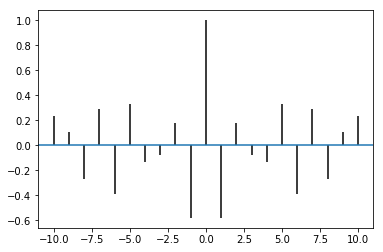

In [6]:
# sigma
plt.acorr(gls_res.resid)

sigma2 = gls_res.resid.dot(gls_res.resid) / (len(y_w)-X.shape[1]+1)
sigma2  # ? way too much?

73286.33930421728

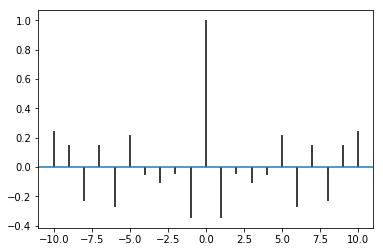

In [9]:
# Ksigma
K = gls_model.cholsigmainv
# K = K.T.dot(K)  # (K'K)\sigma = sigmaI
res_k = K.dot(gls_res.resid)
plt.acorr(res_k)

sigma2 = res_k.dot(res_k) / (len(y_w)-X.shape[1]+1)
sigma2  # this seems in line with the manually prewhitened OLS result,
# so we need to get the dotproduct of K and the residuals instead of just the residuals